In [29]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np
USE_CUDA = torch.cuda.is_available() 
device = torch.device("cuda" if USE_CUDA else "cpu") 
print("device", device)
batch_size = 18
hidden_size = 10
input_size = 2
output_size = 1

class Custom_Activation_F:
    
    def __init__(self, rate = 1):
        self.rate = rate
        
    def logact(a):
        '''
        logistic activation function
        '''
        i = 0
        while i < len(a):
            j = 0
            while j < len(a[i]):
                if a[i][j] > 0:
                    a[i][j] = torch.log(a[i][j] + self.rate)
                else:
                    a[i][j] = - torch.log(self.rate - a[i][j])
                j = j + 1
            i = i + 1
        return a
    
def logact(a):
    '''
    logistic activation function
    '''
    i = 0
    while i < len(a):
        j = 0
        while j < len(a[i]):
            if a[i][j] > 0:
                a[i][j] = torch.log(a[i][j] + 1)
            else:
                a[i][j] = - torch.log(1 - a[i][j])
            j = j + 1
        i = i + 1
    return a

device cpu


In [2]:
class bnn(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = 1
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU(0.1)
        
        self.w1 = nn.Parameter(
            torch.zeros(input_size, self.hidden_size, dtype = torch.float32, requires_grad=True)
        )
        self.b = nn.Parameter(
            torch.zeros(self.hidden_size, dtype = torch.float32,requires_grad=True)
        )
        self.w2 = nn.Parameter(
            torch.zeros(self.hidden_size, output_size, dtype = torch.float32, requires_grad=True)
        )
        
        self.w1_prior = torch.zeros(input_size, hidden_size)
        self.b_prior = torch.zeros(hidden_size)
        self.w2_prior = torch.zeros(hidden_size, output_size)
        
    def _rep(self, mu):
        return mu + torch.randn_like(mu)*0.1
    
    def _update_prior(self, w1, w2, b, rate = 0.1):
        self.w1_prior = w1.clone().detach()*rate + self.w1_prior*(1-rate)
        self.w2_prior = w2.clone().detach()*rate + self.w2_prior*(1-rate)
        self.b_prior = b.clone().detach()*rate + self.b_prior*(1-rate)
        
    def _kldloss(self):
        sum1 = torch.sum(torch.square(self.w1 - self.w1_prior))
        sum2 = torch.sum(torch.square(self.w2 - self.w2_prior))
        sum3 = torch.sum(torch.square(self.b - self.b_prior))
        return sum1 + sum2 + sum3
    
    def forward(self, x, batch_size, rate):
        self.batch_size = batch_size
        b = self._rep(self.b)
        w1 = self._rep(self.w1)
        w2 = self._rep(self.w2)
        b = b.expand(self.batch_size, self.hidden_size)
        x = torch.matmul(x, w1) + b
        x = logact(x)
        x = torch.matmul(x, w2)
        self._update_prior(self.w1_prior, self.w2_prior, self.b_prior, rate)
        #if we want to move prior, we can just subtract _prior term at the upper line
        return x
    
    def bayesian_loss(self, target, output, data_num):
        
        likelihood = torch.sum(torch.square(target - output))
        return likelihood + (self.batch_size/data_num) * self._kldloss()
        


In [3]:
tmp_data = torch.tensor([[-1., 3., 5], [-2, 2, 5], [-0.5, 2, 4], 
                         [-0.5, 1.5, 3], [0.5, 1, 1], [1, 1, -1],
                         [2, 2, -3], [3, 2, -4], [4, 4, -5],
                         [5, 4, -4], [5, 5, -3], [6, 4, -2],
                         [7, 4, -1], [8, 3, 0], [8, 4, 1],
                         [9, 3, 3], [9, 1, 5], [10, 2, 6]])



#we have to save posterior to prior w1, w2, b

In [4]:
mybnn = bnn(input_size, hidden_size, output_size)
train_dataloader = DataLoader(tmp_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SGD(mybnn.parameters(), lr=0.001)


In [18]:
i = 0
while i < 100:
    train_data = next(iter(train_dataloader))
    input_data, target = torch.split(train_data, [input_size, output_size], dim = 1)
    output = mybnn(input_data, batch_size, rate = 0.01)
    loss = mybnn.bayesian_loss(target, output, reg = 1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(loss)
    i = i + 1

tensor(102.5020, grad_fn=<AddBackward0>)


/var/folders/8_/4r7bgqsn54q6km29ph3gjqwc0000gn/T/ipykernel_19261/649124158.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z9 = torch.tensor(z, requires_grad = False).numpy()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


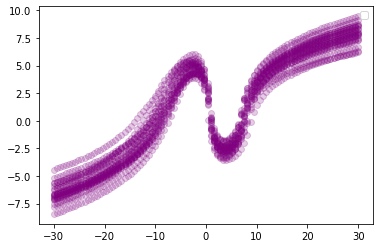

In [19]:
x = np.linspace(-30, 30, 100)
y = np.linspace(4, 4, 100)
newxy = np.concatenate((np.transpose([x]), np.transpose([y])), axis = 1)
newxy = torch.tensor(newxy, dtype = torch.float32)
newxy = torch.reshape(newxy,(100,2))


i = 0
while i<20:
    z = mybnn(newxy,100,0.01)
    Z9 = torch.tensor(z, requires_grad = False).numpy()
    plt.scatter(x, Z9, color = 'purple', alpha = 0.2)
    i = i + 1

plt.legend()
plt.show()

In [30]:
class BayesianLinear(nn.Module):
    
    def __init__(self, i_s, o_s):
        '''
        i_s = input_size
        o_s = output_size
        
        '''
        super().__init__()
        self.b_s = 1
        self.i_s = i_s
        self.o_s = o_s
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU(0.1)
        
        self.w = nn.Parameter(
            torch.zeros(self.i_s, self.o_s, dtype = torch.float32, requires_grad=True)
        )
        self.b = nn.Parameter(
            torch.zeros(self.o_s, dtype = torch.float32, requires_grad=True)
        )
        
        self.w_prior = torch.zeros(self.i_s, self.o_s)
        self.b_prior = torch.zeros(self.o_s)
        
    def _rep(self, mu):
        return mu + torch.randn_like(mu)*0.1
    
    def _update_prior(self, w1, w2, b, rate = 0.1):
        self.w_prior = w.clone().detach()*rate + self.w_prior*(1-rate)
        self.b_prior = b.clone().detach()*rate + self.b_prior*(1-rate)
        
    def kldloss(self):
        sum1 = torch.sum(torch.square(self.w - self.w_prior))
        sum2 = torch.sum(torch.square(self.b - self.b_prior))
        return sum1 + sum2
    
    def forward(self, x):
        self.batch_size = len(x)
        b = self._rep(self.b)
        w = self._rep(self.w)
        b = b.expand(self.b_s, self.o_s)
        x = torch.matmul(x, w) + b
        #self._update_prior(self.w1_prior, self.w2_prior, self.b_prior, rate)
        #if we want to move prior, we can just subtract _prior term at the upper line
        return x
    

In [31]:
class Bayesian_Regress(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.blinear1 = BayesianLinear(input_size, hidden_size)
        self.blinear2 = BayesianLinear(hidden_size, hidden_size)
        self.blinear3= BayesianLinear(hidden_size, output_size)
        self.myact = Custom_Activation_F()
    
    def forward(self, x):
        self.batch_size = len(x)
        x = self.blinear1(x)
        print(np.shape(x))
        print(x)
        x = logact(x)
        x = self.blinear2(x)
        x = self.myact.logact(x)
        x = self.blinear3(x)
        
        #self._update_prior(self.w1_prior, self.w2_prior, self.b_prior, rate)
        #if we want to move prior, we can just subtract _prior term at the upper line
        return x
    
    def kld_loss(self):
        
        L1 = self.blinear1.kldloss()
        L2 = self.blinear2.kldloss()
        L3 = self.blinear3.kldloss()
        
        return (L1+L2+L3)

In [32]:
regressor = Bayesian_Regress(2, 10, 1)

In [33]:
tmp_data = torch.tensor([[-1., 3., 5], [-2, 2, 5], [-0.5, 2, 4], 
                         [-0.5, 1.5, 3], [0.5, 1, 1], [1, 1, -1],
                         [2, 2, -3], [3, 2, -4], [4, 4, -5],
                         [5, 4, -4], [5, 5, -3], [6, 4, -2],
                         [7, 4, -1], [8, 3, 0], [8, 4, 1],
                         [9, 3, 3], [9, 1, 5], [10, 2, 6]])


loss = nn.MSELoss(reduction=sum)
train_dataloader = DataLoader(tmp_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SGD(regressor.parameters(), lr=0.001)



In [34]:
i = 0
batch_size = 18
total_num = 18

while i < 100:
    train_data = next(iter(train_dataloader))
    input_data, target = torch.split(train_data, [input_size, output_size], dim = 1)
    output = regressor(input_data)
    total_loss = loss(output, target)
    total_loss = total_loss + regressor.kld_loss()*(batch_size/total_num)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(loss)
    i = i + 1

torch.Size([18, 10])
tensor([[-0.1389, -0.6798,  0.5295, -1.1996,  1.1417, -1.4219,  0.9839, -0.4408,
         -0.1337, -2.7082],
        [-0.0626, -0.1891,  0.0508, -0.1846, -0.0500, -0.2090, -0.1139, -0.1059,
         -0.1414, -0.0767],
        [-0.1244, -0.6122,  0.2905, -0.6159,  0.0936, -0.9028,  0.0397, -0.5310,
         -0.1895, -1.0074],
        [-0.1332, -0.6460,  0.4778, -1.0816,  0.9640, -1.3002,  0.8225, -0.4325,
         -0.1401, -2.3821],
        [-0.0623, -0.2061, -0.0589,  0.1041, -0.6538,  0.0059, -0.6546, -0.2169,
         -0.1811,  0.8088],
        [-0.1358, -0.6799,  0.3939, -0.8519,  0.4491, -1.1461,  0.3626, -0.5477,
         -0.1766, -1.6596],
        [-0.0655, -0.2060,  0.0767, -0.2436,  0.0388, -0.2698, -0.0332, -0.1100,
         -0.1382, -0.2398],
        [-0.1301, -0.6461,  0.3422, -0.7339,  0.2714, -1.0244,  0.2012, -0.5393,
         -0.1831, -1.3335],
        [-0.1441, -0.7476,  0.3617, -0.7401,  0.1119, -1.1137,  0.0640, -0.6713,
         -0.2067, -1.2632]

TypeError: logact() takes 1 positional argument but 2 were given